# 一些你可能不知道、但有必要知道的python知识点
1. OrderedDict 
2. 以\_\_init\_\_, \_\_setattr\_\_为代表的magic function
3. weakref

## OrderedDict就是有顺序的字典

In [27]:
from collections import OrderedDict
od = OrderedDict()
od['a'] = 1
od['b'] = 2
od['c'] = 3

for i in od:
    print(i)
    
dictionary = dict()
dictionary['a'] = 1
dictionary['b'] = 2
dictionary['c'] = 3
dictionary['d'] = 4
for i in dictionary:
    print(i)

a
b
c
d
a
c
b


# module的五个主要模块
不妨按照这张图，花5到10分钟浏览一下module.py的各个函数。接下来我并不按照五个模块的顺序来阐述，而是按照module.py函数的顺序来讲。

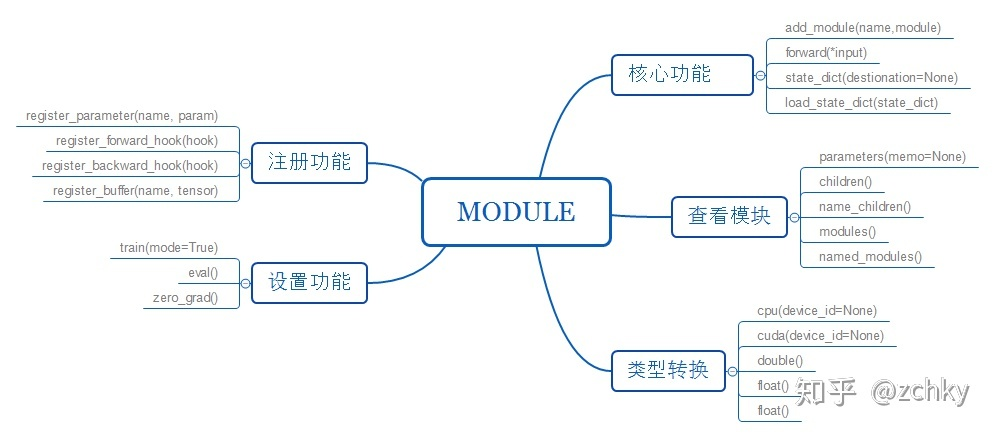

# \_\_init\_\_

- self._parameters 用来存放注册的 Parameter 对象

- self._buffers 用来存放注册的 Buffer 对象。（pytorch 中 buffer 的概念就是 不需要反向传导更新的值）

- self._modules 用来保存注册的 Module 对象。

- self.training 标志位，用来表示是不是在 training 状态下

- ...hooks 用来保存 注册的 hook

## **\_buffers是模型中不需要通过反向传播来更新的量**
最典型的就是BN层中的实现，等具体分析BN层再讲，下面是一个比较直接的例子。

In [28]:
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from collections import OrderedDict
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.register_buffer('multiply', torch.tensor([1,2]))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        x = self._buffer['multiply'] * x
        return x


net = Net()

print('net itself\'s _buffers = ', net._buffers)
print('it\'s {}empty'.format('' if net._buffers == OrderedDict() else 'not '))
print('multiply is {}in net.state_dict()'.format('' if 'multiply' in net.state_dict() else 'not '))
print('#'*20)
for sub_module in net._modules.values():
    print('    ',sub_module)
    print('    ',sub_module._parameters.keys())
    print('    this sub module has {}nodes as buffers'.format('no ' if sub_module._buffers == OrderedDict() else ''))
    print('    *****************')

net itself's _buffers =  OrderedDict([('multiply', tensor([1, 2]))])
it's not empty
multiply is in net.state_dict()
####################
     Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
     odict_keys(['weight', 'bias'])
    this sub module has no nodes as buffers
    *****************
     Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
     odict_keys(['weight', 'bias'])
    this sub module has no nodes as buffers
    *****************
     Linear(in_features=800, out_features=500, bias=True)
     odict_keys(['weight', 'bias'])
    this sub module has no nodes as buffers
    *****************
     Linear(in_features=500, out_features=10, bias=True)
     odict_keys(['weight', 'bias'])
    this sub module has no nodes as buffers
    *****************


# forward
每个具体的Module都要override这个函数才行

# regitster_buffer(self, name, tensor)

In [15]:
     def register_buffer(self, name, tensor):
        # 1. name不能不是string
        if not isinstance(name, torch._six.string_classes):
            raise TypeError("buffer name should be a string. "
                            "Got {}".format(torch.typename(name)))
        # 2. name中不能包含 点.
        elif '.' in name:
            raise KeyError("buffer name can't contain \".\"")
        # 3. name不能为空字符串
        elif name == '':
            raise KeyError("buffer name can't be empty string \"\"")
        # 4. 如果name是module的属性，但是不在_buffer这个字典里面，这就有冲突
        elif hasattr(self, name) and name not in self._buffers:
            raise KeyError("attribute '{}' already exists".format(name))
        # 5. 如果tensor不为空但是又不是真正的torch.Tensor, 也不行。这里我们可能会犯的错误就是用numpy的array来注册buffer
        elif tensor is not None and not isinstance(tensor, torch.Tensor):
            raise TypeError("cannot assign '{}' object to buffer '{}' "
                            "(torch Tensor or None required)"
                            .format(torch.typename(tensor), name))
        else:
            self._buffers[name] = tensor

1. name不能不是string
2. name中不能包含 点.
3. name不能为空字符串
4. 如果name是module的属性，但是不在_buffer这个字典里面，这就有冲突
5. 如果tensor不为空但是又不是真正的torch.Tensor, 也不行。这里我们可能会犯的错误就是用numpy的array来注册buffer(如下代码会报错)

In [26]:
import numpy as np
t = np.array([1,2,2])
net.register_buffer('t', t)

TypeError: cannot assign 'ndarray' object to buffer 't' (torch Tensor or None required)

# register_parameter(self, name, param)

In [63]:
    def register_parameter(self, name, param):
        r"""Adds a parameter to the module.

        The parameter can be accessed as an attribute using given name.

        Args:
            name (string): name of the parameter. The parameter can be accessed
                from this module using the given name
            param (Parameter): parameter to be added to the module.
        """
        # 如果self.__dict__中还没有_parameters，那说明还没有调用__init__
        if '_parameters' not in self.__dict__:
            raise AttributeError(
                "cannot assign parameter before Module.__init__() call")
        
        # name不能不是string
        elif not isinstance(name, torch._six.string_classes):
            raise TypeError("parameter name should be a string. "
                            "Got {}".format(torch.typename(name)))
        # name不能包括 点.
        elif '.' in name:
            raise KeyError("parameter name can't contain \".\"")
        
        # name不应该为空
        elif name == '':
            raise KeyError("parameter name can't be empty string \"\"")
        
        # name已经是module的属性之一，并且不在_parameter里面，这就有冲突
        elif hasattr(self, name) and name not in self._parameters:
            raise KeyError("attribute '{}' already exists".format(name))

        # 如果param是None, 放进_parameters里面
        if param is None:
            self._parameters[name] = None
        
        # 如果param不是Parameter类，不行
        elif not isinstance(param, Parameter):
            raise TypeError("cannot assign '{}' object to parameter '{}' "
                            "(torch.nn.Parameter or None required)"
                            .format(torch.typename(param), name))
        # param.grad_fn要为None。param.grad_fn不为None，就说明param不是叶节点，或者说它是由其他节点来生成的
        # pytorch不允许我们把这类param直接拿来放进一个模型中。
        elif param.grad_fn:
            raise ValueError(
                # TODO
                # 这里是说往模型增加的参数应该是leaf层的, 不过我还不清楚为什么这样

                # 这里是说如果你往模型里面增加了一个已经有了有grad_fn这个属性的参数
                # 那它肯定就不是leaf层的咯，讲得通
                "Cannot assign non-leaf Tensor to parameter '{0}'. Model "
                "parameters must be created explicitly. To express '{0}' "
                "as a function of another Tensor, compute the value in "
                "the forward() method.".format(name))
        else:
            self._parameters[name] = param

1. **如果self.\_\_dict__中还没有\_parameters，那说明还没有调用\_\_init__**
2. name不能不是string
3. name不能包括 点.
4. name不应该为空
5. name已经是module的属性之一，并且不在_parameter里面，这就有冲突
6. 如果param是None, 放进_parameters里面
7. 如果param不是Parameter类，不行
8. param.grad_fn要为None。param.grad_fn不为None，就说明param不是叶节点，或者说它是由其他节点来生成的，pytorch不允许我们把这类param直接拿来放进一个模型中。

**为什么register_parameter需要考虑Module.\_\_init__是否已经调用了，而register_buffer不需要？**
- 做了些实验，我认为需要，已经提交了PR。原因如下面实验。首先跑下面的代码，我们会得到一个报错" Linear object has no attribute '\_buffers' " 

In [ ]:
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import Module
class Linear(Module):
    def __init__(self, in_features, out_features, bias=True):

        self.in_features = in_features
        self.out_features = out_features
        self.register_buffer('test', torch.Tensor(out_features, in_features))
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        super(Linear, self).__init__()
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    

linear = Linear(3,4)

2. 如果我在module.py源代码的第106行前面加上(你也可以去修改一下看看)

```
        if '_buffers' not in self.__dict__:
                raise AttributeError(
                "cannot assign buffer before Module.__init__() call")
```                

并将106行的if not isinstance(name, torch.\_six.string\_classes)改为elif not isinstance(name, torch.\_six.string\_classes):
那么上述代码的报错就是"cannot assign buffer before Module.__init__() call"，这样用户就会更清楚它应该先super(Linear, self).\_\_init\_\_()

# add_module
逻辑跟上述的差不多，不赘述

# \_apply(self, fn)
1. 以\_开头的方法都是隐方法，就是建议用户不要直接调用的方法
2. fn最终是作用于module的param和buffer

# apply(self, fn)
我认为跟\_apply的区别就是fn的区别，在这里fn是随意的所有对module的操作，而上面的\_apply的fn是对module的param和buffer作用的

In [4]:
import torch.nn as nn
def init_weights(m):
                    print(m)
                    if type(m) == nn.Linear:
                        m.weight.data.fill_(1.0)
                        print(m.weight)

net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)


Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)

# cuda、cpu、type、float、double、half、to等方法=\_apply(self, 具体的fn)

# hook
1. 重要结论：
    - hook只是辅助工具，它本身并不参与forward或者backward的任何计算。
    - 在hook中你可以定义任何辅助的操作，常见的就是打印中间节点的grad-->原因是如果forward或者backward之后，中间节点的grad不会保存。
2. hook的意义
    - 如1中说的，可以帮助打印grad
    - 为什么要专门有个hook来帮助打印，而不直接去调用参数的grad的呢？因为当我们backward的过程中，对于算完grad的中间节点，一旦它的子节点的grad算完，它的grad就被释放了，这样可以帮助节省内存。
3. [参照](https://oldpan.me/archives/pytorch-autograd-hook)

In [5]:
    def register_backward_hook(self, hook):
        handle = hooks.RemovableHandle(self._backward_hooks)  # 这句暂时你直接忽略
        self._backward_hooks[handle.id] = hook
        return handle

# TODO pytorch的动态图妙处
module加tensor模块，理解透彻之后，我们应该能体会到pytorch的动态图妙处。暂时我还体会不够深刻，所以很可能需要tensor那一部分。
[如何理解pytorch的动态计算图](https://zhuanlan.zhihu.com/p/33378444)

# TODO 然后，为什么静态图更高效？？动态图和静态图在底层上的区别是什么？

# TODO \_tracing_name、_slow_forward涉及jit，暂按不表

# \_\_call\_\_

In [2]:
    def __call__(self, *input, **kwargs):
        for hook in self._forward_pre_hooks.values():
            hook(self, input)
        if torch.jit._tracing:
            result = self._slow_forward(*input, **kwargs)
        else:
            result = self.forward(*input, **kwargs)
        for hook in self._forward_hooks.values():
            hook_result = hook(self, input, result)
            if hook_result is not None:
                raise RuntimeError(
                    "forward hooks should never return any values, but '{}'"
                    "didn't return None".format(hook))
        if len(self._backward_hooks) > 0:
            var = result
            ### 以下这几行可能是为了解决当result是_slow_forward产生的时候，我们来得到
            while not isinstance(var, torch.Tensor):
                if isinstance(var, dict):
                    var = next((v for v in var.values() if isinstance(v, torch.Tensor)))
                else:
                    var = var[0]
            grad_fn = var.grad_fn

            #　TODO: 不太懂，需要明白grad_fn.register_hook跟module.register_hook的区别和联系
            if grad_fn is not None:
                for hook in self._backward_hooks.values():
                    wrapper = functools.partial(hook, self)
                    functools.update_wrapper(wrapper, hook)
                    grad_fn.register_hook(wrapper)
        return result

# \_\_setstate\_\_和\_\_getstate\_\_都比较简单
- 为什么在\_\_setstate\_\_中需要专门再声明\_forward\_pre_hooks?

# 重点：\_\_setattr\_\_
1. \_\_setattr\_\_控制着实例的属性赋值。比如, m = Module(), 然后**m.\_parameters = OrderedDict()时**，其实是会跳转进\_\_setattr\_\_(m, \_parameters, OrderedDict())，进入这个函数的逻辑。
2. 你有没有想过，为什么我们用pytorch定义好网络结构之后，然后调用state_dict就能看到参数呢,如下

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
class My_net(nn.Module):
    def __init__(self):
        super(My_net, self).__init__()
       	# Conv layer 1
        self.cl1 = nn.Linear(2, 3)

    def forward(self, x):
        # conv layer 1
        x = self.cl1(x)
        return x

model = My_net()
model.state_dict()

OrderedDict([('cl1.weight', tensor([[ 0.4198, -0.0329],
                      [ 0.5594, -0.1598],
                      [ 0.0456, -0.0754]])),
             ('cl1.bias', tensor([ 0.2590,  0.2400, -0.6707]))])

3. 事实上逻辑是这样的，当我们调用state_dict()时，它会将它自身的param和buffer加进OrderedDict，然后再将它的子module的param和buffer加进去。这个看源代码很容易。可是，我们并没有显式地将变量放进param和buffer,对吗？那么pytorch是怎么帮助我们完成的？
4. 回到\_\_set\_\_的源代码，它是这么处理的：先检查你的value是不是param类型的，如果是的话，将它注册进parameter(register_parameter)中，不是的话再检查是不是module，然后是不是buffer，都不是的话最后用最普通的object.__setattr__(self, name, value) （最后一行）来声明。

**_下面的请暂时忽略，可能是不对的。_**

报错的原因是,运行到self.weight = Parameter(torch.Tensor(out_features, in_features)), python解释器会运行\_\_setattr\_\_(self, 'weight', Parameter(torch.Tensor(out_features, in_features)))。进入\_\_setattr\_\_后，检查到Parameter(torch.Tensor(out_features, in_features)))是parameter，所以解释器试图将注册Parameter(torch.Tensor(out_features, in_features)))，即把Parameter(torch.Tensor(out_features, in_features)))放进self.\_parameters，此时你发现根本没有self.\_parameters，原因是你还没有super(Linear, self).\_\_init\_\_。

而对应地，__setattr__里面并没有用到register_buffers，而是直接用的buffers[name]=param。同时，很重要的一点是，当你命令self.xxx = yyy时，因为\_\_setattr\_\_里面不能根据你的yyy的类型判断yyy是buffer；而是根据xxx是不是在已经有的self.\_buffer中，如果不在，就把xxx当成普通attribute。也就是说，self.xxx = yyy是不能隐形地注册buffers的，那么你要注册buffers，只能显式地自己调用register_buffer。那么
    1. 你是在super(Linear, self).\_\_init\_\_之前register,那么它会发现没有self没有_buffer,就会自动报错。

# 后面的所有方法都不赘述，简单，但是最好自己过一遍源代码吧

**下面代码都不用看，是我的测试，因为担心还会用到就没删**

In [84]:
x = torch.randn((2, 2))
y = torch.randn((2, 2))
z = torch.randn((2, 2), requires_grad=True)
a = x + y
b = a + z
print(x.grad_fn, a.grad_fn)
print(x.requires_grad, y.requires_grad, z.requires_grad)
print(a.requires_grad, b.requires_grad)
print(b.is_leaf)

None None
False False True
False True
False


In [69]:
class foo(object):
    def __init__(self, x):
        self.name = x
    def add(self, y):
        self.name['a'] = y
    def __setattr__(self, name, value):
        print('into setattr')
        object.__setattr__(self, name, value)

In [70]:
f = foo({'b':2})

into setattr


In [71]:
f.name

{'b': 2}

In [72]:
f.add(3)

In [73]:
f.name

{'a': 3, 'b': 2}

In [110]:
import weakref
from collections import OrderedDict
test = OrderedDict({'a':1})
t2 = weakref.ref(test)
print(t2())
test['b'] = 2

print(t2())

OrderedDict([('a', 1)])
OrderedDict([('a', 1), ('b', 2)])


In [132]:
import collections
import weakref


class RemovableHandle(object):
    """A handle which provides the capability to remove a hook."""

    next_id = 0

    def __init__(self, hooks_dict):
        self.hooks_dict_ref = weakref.ref(hooks_dict)
        print(self.hooks_dict_ref())
        self.id = RemovableHandle.next_id
        RemovableHandle.next_id += 1

    def remove(self):
        hooks_dict = self.hooks_dict_ref()
        if hooks_dict is not None and self.id in hooks_dict:
            del hooks_dict[self.id]

    def __getstate__(self):
        return (self.hooks_dict_ref(), self.id)

    def __setstate__(self, state):
        if state[0] is None:
            # create a dead reference
            self.hooks_dict_ref = weakref.ref(collections.OrderedDict())
        else:
            self.hooks_dict_ref = weakref.ref(state[0])
        self.id = state[1]
        RemovableHandle.next_id = max(RemovableHandle.next_id, self.id + 1)

    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.remove()


class foo1:
    def __init__(self, x):
        self.orderdict = x
    def register_hook(self, hook):
        "实例化RemovableHandle，实例化的时候打印一下ref"
        handle = RemovableHandle(self.orderdict)
        self.orderdict[handle.id] = hook
        "经过上面这一步，原先的orderdict改变了，ref也就同步改变了"
        print(handle.hooks_dict_ref())
        return handle

In [140]:
d = OrderedDict({'a':1})
f1 = foo1(d)
handle = f1.register_hook(print)
handle.remove()
print(f1.orderdict)
f1.orderdict = None
print(f1.orderdict)
print(handle.hooks_dict_ref())

OrderedDict([('a', 1)])
OrderedDict([('a', 1), (7, <built-in function print>)])
OrderedDict([('a', 1)])
None
OrderedDict([('a', 1)])


In [116]:
f1

OrderedDict([('a', 1), (0, <function print>)])

In [31]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MyMul(nn.Module):
    def forward(self, input):
        out = input * 2
        return out

class MyMean(nn.Module):            # 自定义除法module
    def forward(self, input):
        out = input/4
        return out

def tensor_hook(grad):
    print('tensor hook')
    print('grad:', grad)
    return grad

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.f1 = nn.Linear(4, 1, bias=True)    
        self.f2 = MyMean()
        self.weight_init()

    def forward(self, input):
        self.input = input
        output = self.f1(input)       # 先进行运算1，后进行运算2
        output = self.f2(output)     
        return output

    def weight_init(self):
        self.f1.weight.data.fill_(8.0)    # 这里设置Linear的权重为8
        self.f1.bias.data.fill_(2.0)      # 这里设置Linear的bias为2

    def my_hook(self, module, grad_input, grad_output):
        print('doing my_hook')
        print('original grad:', grad_input)
        print('original outgrad:', grad_output)
        # grad_input = grad_input[0]*self.input   # 这里把hook函数内对grad_input的操作进行了注释，
        # grad_input = tuple([grad_input])        # 返回的grad_input必须是tuple，所以我们进行了tuple包装。
        # print('now grad:', grad_input)        
#         grad_input_ = (grad_input[0] * 2,)
#         print('grad_input_', grad_input_)
#         return grad_input_
        return grad_input

if __name__ == '__main__':

    input = torch.tensor([1, 2, 3, 4], dtype=torch.float32, requires_grad=True).to(device)

    net = MyNet()
    net.to(device)

    net.register_backward_hook(net.my_hook)   # 这两个hook函数一定要result = net(input)执行前执行，因为hook函数实在forward的时候进行绑定的
    input.register_hook(tensor_hook)
    result = net(input)

    print('result =', result)

    result.backward()

    print('input.grad:', input.grad)
    for param in net.parameters():
        print('{}:grad->{}'.format(param, param.grad))
    
    print('*'*20)
    from collections import OrderedDict
    print(net._parameters == OrderedDict())
    for name, param in net.named_parameters():
        print('{}, {}:grad->{}'.format(name, param, param.grad))

result = tensor([20.5000], grad_fn=<DivBackward0>)
doing my_hook
original grad: (tensor([0.2500]),)
original outgrad: (tensor([1.]),)
tensor hook
grad: tensor([2., 2., 2., 2.])
input.grad: tensor([2., 2., 2., 2.])
Parameter containing:
tensor([[8., 8., 8., 8.]], requires_grad=True):grad->tensor([[0.2500, 0.5000, 0.7500, 1.0000]])
Parameter containing:
tensor([2.], requires_grad=True):grad->tensor([0.2500])
********************
True
f1.weight, Parameter containing:
tensor([[8., 8., 8., 8.]], requires_grad=True):grad->tensor([[0.2500, 0.5000, 0.7500, 1.0000]])
f1.bias, Parameter containing:
tensor([2.], requires_grad=True):grad->tensor([0.2500])


In [19]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cl1 = nn.Linear(25, 60)
        self.cl2 = nn.Linear(60, 16)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


activation = {}
def get_activation(name):
    def hook(model, input, output):
        print('output = ', output)
        activation[name] = output.detach()
    return hook


model = MyModel()
model.fc2.register_forward_hook(get_activation('fc2'))
x = torch.randn(1, 25)
output = model(x)
print(activation['fc2'])

output =  tensor([[ 0.0780,  0.0132, -0.0352, -0.0993, -0.1197, -0.1113, -0.0462, -0.0224,
         -0.0404,  0.1469, -0.0085,  0.0462,  0.1228, -0.1451,  0.0909,  0.0354,
         -0.0587,  0.0618,  0.1080, -0.0590,  0.0798, -0.0107,  0.0759, -0.0223,
         -0.0489,  0.2252, -0.0938, -0.0134, -0.0225,  0.0924, -0.0636,  0.0210,
          0.0950,  0.0471, -0.1258, -0.0757,  0.0412, -0.0364, -0.0228, -0.0309,
          0.1073,  0.0644,  0.0114,  0.0733,  0.1834, -0.1132,  0.1290,  0.0338,
          0.0506, -0.0158, -0.0699,  0.0702,  0.0391, -0.0346, -0.0066, -0.0367,
          0.0526, -0.0827, -0.0741, -0.0956,  0.0238, -0.0436, -0.1333,  0.1485,
         -0.1303,  0.1627, -0.0377,  0.0436, -0.0240,  0.0970,  0.0771,  0.1288,
         -0.0429, -0.0233, -0.0018, -0.1367,  0.1371,  0.1156, -0.0719, -0.0289,
         -0.0487,  0.0045, -0.1997,  0.0302]], grad_fn=<ThAddmmBackward>)
tensor([[ 0.0780,  0.0132, -0.0352, -0.0993, -0.1197, -0.1113, -0.0462, -0.0224,
         -0.0404,  0.1469